# Lesson 1 - Introduction to random forests


### Learning objectives


* **bold text** Gain an introduction to the pandas library
* Understand the main steps involved in training a machine learning model
* Gain an introduction to scikit-learn's API
* Understand the need to generate a training and validation set

* Chapters 2 & 3 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Geron
* Section VII of [_A high-bias, low-variance introduction to Machine Learning for physicists_](https://arxiv.org/abs/1803.08823) by P. Mehta et al.
* [Searching for exotic particles in high-energy physics with deep learning](https://www.nature.com/articles/ncomms5308) by Baldi et al.

**bold text**## The data

We will be analysing SUSY data from the [Searching for exotic particles in high-energy physics with deep learning](https://www.nature.com/articles/ncomms5308) article by Baldi et al. (2014). The dataset can be obtained from the [UCI Machine Learning repository](http://archive.ics.uci.edu/ml/datasets/SUSY#) and is described as follows:

> The data has been produced using Monte Carlo simulations. The first 8 features are kinematic properties measured by the particle detectors in the accelerator. The last ten features are functions of the first 8 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks and the dropout algorithm are presented in the original paper. The last 500,000 examples are used as a test set.

Framed as a supervised learning task, the goal is to train a model that can classify each event as either a SUSY signal or Standard Model background (see figure below).

<div style="text-align: center">
<img src='images/susy.png' width='400'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://www.nature.com/articles/ncomms5308 </p>
</div>

The dataset description also provides information on the features or kinematic variables associated with with each event:

> The first column is the class label (1 for signal, 0 for background), followed by the 18 features (8 low-level features then 10 high-level features): lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1).

In [9]:
# reload  modules before executing user code
%load_ext autoreload

# reload all modules every time before every time before executing python code
%autoreload 2

# render plots in notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# uncomment this if running locally or on Google Colab
# !pip install --upgrade hepml

In [15]:
# data wrangling
import pandas as pd
import numpy as np
from pathlib import Path
from hepml.core import display_large, download_dataset

#data viz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

sns.set(color_codes = True)
sns.set_palette(sns.color_palette("muted"))

#ml magic
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

**bold text**## Load the data

For simplicity, we have stored a copy of the data on Google Drive which 

*   List item
*   List item

can be fetched by running the following function:

In [17]:
# this is a big file and can take a while to download
download_dataset("susy.csv.gz")

Download of susy.csv.gz dataset complete.


To load our dataset we need to tell pandas where to look for it. First, lets have a look at what we have in the `data/` directory:

In [18]:
DATA = Path("../data")
!ls {DATA}

FashionMNIST	 percent-bachelors-degrees-women-usa.csv  training_10k.csv
Higgs_data.root  susy.csv.gz
Mountains.csv	 titanic


With pathlib it is a simple matter to define the filepath to the dataset, and since the file is in a (compressed) CSV format we can load it as a pandas.DataFrame as follows

In [19]:
columns = [
    "signal",
    "lepton 1 pT",
    "lepton 1 eta",
    "lepton 1 phi",
    "lepton 2 pT",
    "lepton 2 eta",
    "lepton 2 phi",
    "missing energy magnitude",
    "missing energy phi",
    "MET_rel",
    "axial MET",
    "M_R",
    "M_TR_2",
    "R",
    "MT2",
    "S_R",
    "M_Delta_R",
    "dPhi_r_b",
    "cos(theta_r1)",
]

# this can take a while to load ...
%time susy = pd.read_csv(DATA / "susy.csv.gz", compression="gzip", names=columns)

CPU times: user 29.1 s, sys: 1 s, total: 30.1 s
Wall time: 30.1 s


Loading and saving large datasets like this one can be a major bottleneck in the exploratory phase of a machine learning project. Fortunately there are several _binary_ formats that can be used for storing data on disk, and [Feather](https://blog.rstudio.com/2016/03/29/feather/) is one of the fastest for I/O and memory usage (see [benchmark](https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d)). 

Thus one way to speed up our I/O cycles is to first save our `pandas.DataFrame` to disk in Feather format so we can reuse it in downstream tasks:

In [20]:
susy.to_feather(DATA / "susy.feather")

In [21]:
%time susy = pd.read_feather(DATA/'susy.feather')

CPU times: user 813 ms, sys: 845 ms, total: 1.66 s
Wall time: 418 ms


That's about 100x speedup factor - not bad!

*italicized text*> Warning: Although an excellent choice for most applications, Feather is not intended for long-term storage because the format may not be stable between versions. See https://blog.rstudio.com/2016/03/29/feather/

[link text](https://)## Inspect the data

### Preview the data

This first thing you should do after creating a `pandas.DataFrame` is to inspect the first/last few rows to make sure there's no surprises in the data format that need to be dealt with. For example, one often finds metadata or aggregations at the end of CSV/Excel files, and this can cause problems if not handled correctly.

The DataFrame.head method displays the first five rows of a pandas.DataFrame:



In [22]:
susy.head()

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


If we want to see more rows, we just pass an integer argument to the method as follows:


In [25]:
susy.head(10)

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859
5,0.0,0.456398,1.099371,1.512453,0.751772,0.638967,-0.742216,0.322601,1.321054,0.169502,0.359941,0.489256,0.416168,0.754829,0.303750,0.461067,0.345541,0.733242,0.186044
6,0.0,0.437818,-1.119883,-1.336823,0.502320,-1.717515,1.017067,0.215619,-0.461200,0.323671,0.173626,0.411898,0.370525,0.798260,0.671369,0.385910,0.515522,0.479110,0.029058
7,0.0,0.571656,0.205696,0.425950,0.578514,0.927399,-1.101478,0.116555,1.549753,0.174421,0.223450,0.523164,0.289889,0.491710,0.334593,0.514246,0.268207,0.315795,0.125728
8,1.0,2.112812,0.742983,-0.330539,0.805253,-0.028887,-1.446679,2.299946,1.450429,2.989110,-1.894770,1.445125,2.548166,1.564721,2.393632,1.554566,2.148468,1.179117,0.688057
9,0.0,1.001869,-0.471788,0.555614,1.233368,1.255548,-1.052491,0.437615,-1.333052,0.326858,-0.111678,1.435708,0.755201,0.466779,0.454541,1.446331,0.592259,1.325197,0.083014


Similar to DataFrame.head, the DataFrame.tail method returns the last five rows of a pandas.DataFrame:



In [26]:
susy.tail()

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
4999995,1.0,0.853325,-0.961783,-1.487277,0.678190,0.493580,1.647969,1.843867,0.276954,1.025105,-1.486535,0.892879,1.684429,1.674084,3.366298,1.046707,2.646649,1.389226,0.364599
4999996,0.0,0.951581,0.139370,1.436884,0.880440,-0.351948,-0.740852,0.290863,-0.732360,0.001360,0.257738,0.802871,0.545319,0.602730,0.002998,0.748959,0.401166,0.443471,0.239953
4999997,0.0,0.840389,1.419162,-1.218766,1.195631,1.695645,0.663756,0.490888,-0.509186,0.704289,0.045744,0.825015,0.723530,0.778236,0.752942,0.838953,0.614048,1.210595,0.026692
4999998,1.0,1.784218,-0.833565,-0.560091,0.953342,-0.688969,-1.428233,2.660703,-0.861344,2.116892,2.906151,1.232334,0.952444,0.685846,0.000000,0.781874,0.676003,1.197807,0.093689
4999999,0.0,0.761500,0.680454,-1.186213,1.043521,-0.316755,0.246879,1.120280,0.998479,1.640881,-0.797688,0.854212,1.121858,1.165438,1.498351,0.931580,1.293524,1.539167,0.187496


Whenever we have a new dataset it is handy to begin by getting an idea of how large the pandas.DataFrame is. This can be done with either the len or DataFrame.shape methods:

In [27]:
# get number of rows
len(susy)

5000000

In [28]:
# get tuples of (n_rows, n_columns)
susy.shape

(5000000, 19)

The DataFrame.info method is useful to get a quick description of the data, in particular the total number of rows, and each column's type and number of non-null values.



In [29]:
susy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   signal                    float64
 1   lepton 1 pT               float64
 2   lepton 1 eta              float64
 3   lepton 1 phi              float64
 4   lepton 2 pT               float64
 5   lepton 2 eta              float64
 6   lepton 2 phi              float64
 7   missing energy magnitude  float64
 8   missing energy phi        float64
 9   MET_rel                   float64
 10  axial MET                 float64
 11  M_R                       float64
 12  M_TR_2                    float64
 13  R                         float64
 14  MT2                       float64
 15  S_R                       float64
 16  M_Delta_R                 float64
 17  dPhi_r_b                  float64
 18  cos(theta_r1)             float64
dtypes: float64(19)
memory usage: 724.8 MB


*Luckily* for us, it looks like we're dealing with purely numeric data types and there's no missing values 🥳🥳🥳! Let's verify the latter is indeed true:

In [30]:
assert susy.isnull().sum().sum() == 0

[link text](https://)## A first look a data visualisation


Another quick way to get a feel for the type of numeric data that you are dealing with is to plot one or more of the following:

* **Histograms:** shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). Useful for understanding the _shape_ of a single variable.
* **Count plots:** shows the counts of observations in each categorical bin using bars. A count plot can be thought of as a histogram across a categorical, instead of quantitative, variable.

To create these plots we will use the [seaborn](https://seaborn.pydata.org/) data visualisation library. In the same way that `pd` is the accepted alias for pandas, one uses `sns` as the alias for seaborn.


### Histograms

Histograms are one of the most simple, yet powerful types of data visualisation. They can quickly tell us which values are most frequent, whether there are outliers and more. To create a histogram in seaborn, we can use the `seaborn.distplot` method:

<AxesSubplot:xlabel='axial MET', ylabel='Count'>

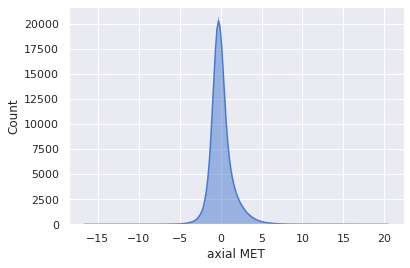

In [33]:
sns.histplot(susy.query("signal == 1")["axial MET"], kde= True)

<AxesSubplot:xlabel='axial MET', ylabel='Count'>

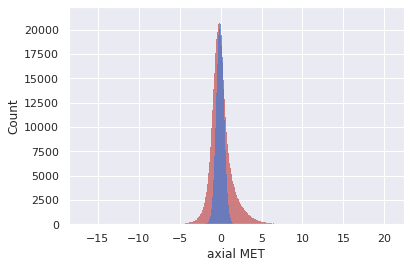

In [40]:
sns.histplot(susy.query("signal == 1")["axial MET"], kde= False, color = 'r')
sns.histplot(susy.query("signal == 0")["axial MET"], kde= False)

<AxesSubplot:ylabel='Frequency'>

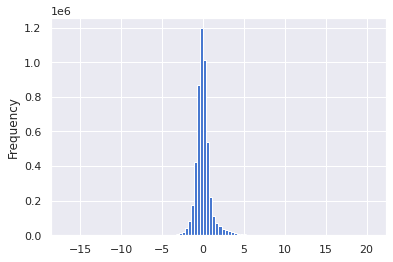

In [43]:
susy['axial MET'].plot.hist(bins=100)

/home/sraj/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/sraj/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


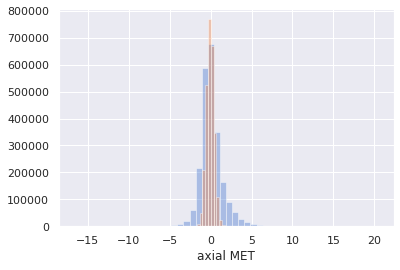

In [44]:
sns.distplot(susy.query("signal == 1")["axial MET"], kde=False)
sns.distplot(susy.query("signal == 0")["axial MET"], kde=False)
plt.show()

Doing this manually for each feature of interest is tiresome, so let's write a simple function that generalises the process:

In [51]:
def plot_histogram(feature_name: str, df: pd.DataFrame):
    sns.distplot(df.query("signal == 1")[feature_name], label="Signal", kde=False)
    sns.distplot(df.query("signal == 0")[feature_name], label="Background", kde=False)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.show()

/home/sraj/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


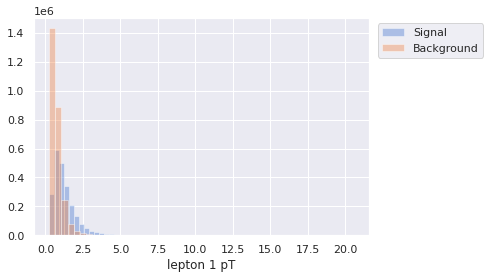

In [52]:
plot_histogram("lepton 1 pT", susy)

/home/sraj/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


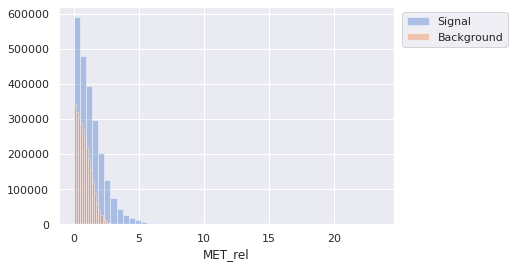

In [53]:
plot_histogram("MET_rel", susy)

> Note: In the plots above, we see that we're dealing with a mix of normal and log-normal distributions. For some machine learning algorithms (e.g. Logistic Regression), these long-tailed distributions may require additional transformations in order to not violate the underlying statistical assumptions. Fortunately for us, Random Forests are flexible enough that we do not need to worry about this!

**bold text**### Count plots

Count plots are handy when you have a categorical feature like `signal` and you want to quickly see the frequencies per category: 

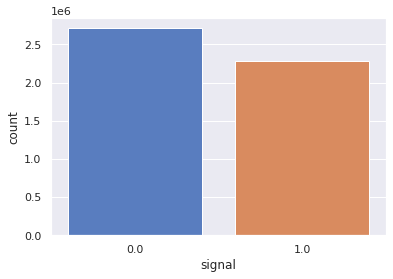

In [56]:
sns.countplot(x ="signal", data= susy)
plt.show()

In [57]:
susy["signal"].value_counts(normalize=True)

0.0    0.542435
1.0    0.457565
Name: signal, dtype: float64

From the plot and numbers we see that the "signal" and "background" classes are nearly balanced, so if we built a dumb classifier that just classifies every single event as "background", then we would be right about 54.2% of the time. Clearly our goal is to do much better than this!

## Create a test set

Before diving into the model-building phase, let's create a test set to limit ourselves from the [data snooping bias](https://web.ma.utexas.edu/users/mks/statmistakes/datasnooping.html). According to the dataset [description](http://archive.ics.uci.edu/ml/datasets/SUSY#) the last 500,000 rows are used as the test set in the original article, so let's use the same set here:

In [61]:
susy_train = susy.copy().iloc[:4500000]
susy_test = susy.copy().iloc[-500000:]

In [62]:
# sanity check on number of rows
assert len(susy_train) == 4_500_000
assert len(susy_test) == 500_000

Let's also save these files to disk for later use:

In [63]:
susy_train.to_feather(DATA / "susy_train.feather")
# feather requires a default pandas.DataFrame index
susy_test.reset_index(drop=True).to_feather(DATA / "susy_test.feather")

## Speeding things up

With 4.5 million events in our dataset, it will be time-consuming to train our models. One way to speed up the rate of iteration, is to select a random sample of 100,000 events to work with:

In [64]:
susy_sample = susy_train.sample(n=100000, random_state=42)

While we are at it, let's create three `pandas.DataFrame` objects, one for:

* low-level features: these are direct measurements of final state particles, in this case the pT , pseudo-rapidity η, and azimuthal angle φ of two leptons in the event and the amount of missing transverse momentum (MET) together with its azimuthal angle.
* high-level features: these are higher order functions of the first 8 features and derived by physicists to help discriminate between the two classes. These high-level features can be thought of as the physicists’ attempt to use non-linear functions to classify signal and background events, having been developed with formidable theoretical effort.
* all features: the full set of 18 input features

In [65]:
low_features = [
    "signal",
    "lepton 1 pT",
    "lepton 1 eta",
    "lepton 1 phi",
    "lepton 2 pT",
    "lepton 2 eta",
    "lepton 2 phi",
    "missing energy magnitude",
    "missing energy phi",
]

high_features = [
    "signal",
    "MET_rel",
    "axial MET",
    "M_R",
    "M_TR_2",
    "R",
    "MT2",
    "S_R",
    "M_Delta_R",
    "dPhi_r_b",
    "cos(theta_r1)",
]

susy_low = susy_sample[low_features].copy()
susy_high = susy_sample[high_features].copy()
susy_all = susy_sample.copy()

> Tip: whenever you use indexing to create a subset of a `pandas.DataFrame`, it is good practice to use the `DataFrame.copy` method to make a copy of the original data. The reason for this is due to the way in which pandas distinguishes a "view" and "copy" of a `pandas.DataFrame`, and not forcing pandas to make a copy can have unintended side-effects in downstream analysis. For an in-depth discussion see https://www.dataquest.io/blog/settingwithcopywarning/

## Introducing scikit-learn

Now that we've checked that the training data is clean and free from obvious anomalies, it's time to train our model! To do so, we will make use of the scikit-learn library.

scikit-learn is one of the best known Python libraries for machine learning and provides efficient implementations of a large number of common algorithms. It has a uniform _Estimator API_ as well as excellent online documentation. The main benefit of its API is that once you understand the basic use and syntax of scikit-learn for one type of model, switching to a new model or algorithm is very easy.

**Basics of the API**

The most common steps one takes when building a model in scikit-learn are:
1. Choose a class of model by importing the appropriate estimator class from scikit-learn.
2. Choose model _hyperparameters_ by instantiating this class with the desired values.
3. Arrange data into a feature matrix and target vector (see discussion below).
4. Fit the model to your data by calling the `fit()` method.
5. Evaluate the predictions of the model:
    * For supervised learning we typically predict _labels_ for new data using the `predict()` method.
    * For unsupervised learning, we often transform or infer properties of the data using the `transform()` or `predict()` methods.
    
Let's go through each of these steps to build a Random Forest regressor to predict California housing prices.

### Choose a model

In scikit-learn, every class of model is represented by a Python class. We want a Random Forest classifier, so looking at the online [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) we should import the `RandomForestClasifier`:

In [66]:
from sklearn.ensemble import RandomForestClassifier

### Choose hyperparameters

Once we have chosen our model class, there are still some options open to us:

* What is the maximum depth of the tree? The default is `None` which means the nodes are expanded until all leaves are pure.
* Other parameters can be found in the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier), but for now we take a simple model with just 20 trees.

The above choices are often referred to as _hyperparameters_ or parameters that must be set before the model is fit to the data. We can instantiate the `RandomForestClassifier` class and specify the desired hyperparameters as follows:

In [67]:
model = RandomForestClassifier(n_estimators=10, n_jobs=-1)

### Arrange data into a feature matrix and target vector

scikit-learn requires that the data be arranged into a two-dimensional feature matrix and a one-dimensional target array. By convention: 

* The feature matrix is often stored in a variable called `X`. This matrix is typically two-dimensional with shape `[n_samples, n_features]`, where `n_samples` refers to the number of rows (i.e. events in our case) and `n_features` refers to all columns except `signal` which is our target.
* The target or label array is usually denoted by `y`.

In [68]:
X = susy_all.drop("signal", axis=1)
y = susy_all["signal"]

### Fit the model to your data

Now it is time to apply our model to data! This can be done with the `fit()` method:

In [69]:
%time model.fit(X, y)

CPU times: user 6.11 s, sys: 54.2 ms, total: 6.16 s
Wall time: 1.45 s


RandomForestClassifier(n_estimators=10, n_jobs=-1)

### Evaluate the predictions

The final step is to generate predictions and evaluate them against some performance metric, e.g. accuracy:

In [70]:
preds = model.predict(X)
accuracy_score(y, preds)

0.98453

<div style="text-align: center">
<img src='images/wat.jpeg'>
</div>

Wait, wat!? How can the Random Forest model have almost no error at all? Is this a perfect model? Of course it is much more likely that the model has badly overfit the data. To be sure we need to use part of the training set for training and part for model validation.

> Warning: Evaluating our model's predictions on the same data it was trained on is almost always a recipe for disaster! Why? The problem is that the model may memorise the structure of the data it sees and fail to provide good predictions when shown new data.

## Better evaluation using training and validation splits

One way to measure how well a model will generalise to new cases is to split your data into two sets: the _**training set**_ and the _**validation set**_. As these names imply, you train your model using the training set and validate it using the validation set. The error rate on new cases is called the _**generalisation error**_ and by evaluating your model on the validation set, you get an estimation of this error.

Creating a validation set is theoretically quite simple: just pick some instances randomly and set them aside (we set the random number generator's seed `random_state` so that is always generates the same shuffled indices):

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset split: {len(X_train)} train rows + {len(X_valid)} valid rows")

Dataset split: 80000 train rows + 20000 valid rows


## Baseline model

With these two datasets, we first fit on the training set and evaluate the prediction on the validation one. To simplify the evaluation of our models, let's write a simple function to keep track of the scores:

In [72]:
def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
    }
    if hasattr(fitted_model, "oob_score_"):
        res["OOB accuracy:"] = fitted_model.oob_score_

    for k, v in res.items():
        print(k, round(v, 3))

In [73]:
model = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [74]:
print_scores(model)

Accuracy on train: 0.985
ROC AUC on train: 0.999
Accuracy on valid: 0.782
ROC AUC on valid: 0.84


## ROC curves and AUC
Note that in addition to accuracy, we also show a second value, the _**Area Under the ROC Curve**_ (AUC). The AUC is a good summary statistic of the predictiveness of a binary classifier. It varies from zero to one, and a value of 0.5 corresponds to randomness (the classifier cannot distinguish at all between "signal" and "background"), while a value of 1.0 means that it is perfect.

The "ROC" refers to the Receiver Operating Characteristic curve which plots the _true positive rate_ 

$$ \mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}} \,, \qquad \mathrm{TP\, (FP)}  = \mathrm{number\, of\, true\, (false) \,positives}\,,$$

against the _false positive rate_ FPR, where the FPR is the ratio of negative instances that are incorrectly classified as positive. In general there is a tradeoff between these two quantities: the higher the TPR, the more false positives (FPR) the classifier produces.

For our analysis, these ROC curves effectively plot signal efficiency versus background rejection at various thresholds of some discriminating variable. Here that variable will be the output signal probability of our Random Forest model. Let's write a simple function to visualise these outputs:

In [76]:
def plot_signal_vs_background(fitted_model):
    valid_probs = model.predict_proba(X_valid)
    df = pd.DataFrame({"probability": valid_probs[:, 1]})
    df["signal"] = y_valid.values
    sns.distplot(
        df.query("signal == 1")["probability"],
        kde=False,
        bins=np.linspace(0, 1, 10),
        label="Signal",
    )
    sns.distplot(
        df.query("signal == 0")["probability"],
        kde=False,
        bins=np.linspace(0, 1, 10),
        label="Background",
    )
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.show()

/home/sraj/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


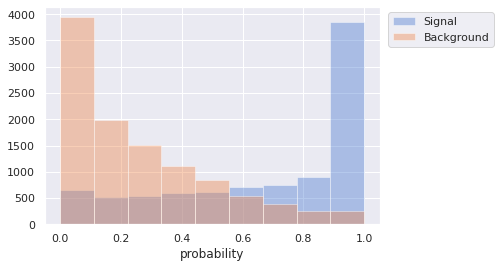

In [77]:
plot_signal_vs_background(model)

We see that although the model assigns high (low) probabilities to the signal (background) events, a fair amount of the signal events overlap with background ones. Another way to see this is to look at the $p_T$ distributions of two highest $p_T$ leptons:

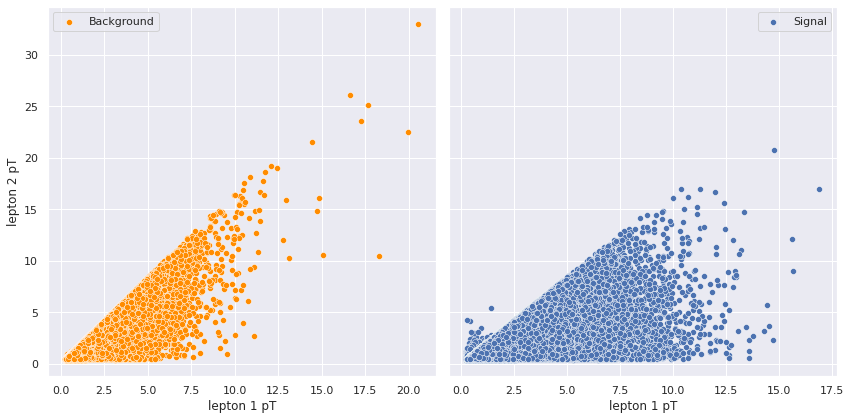

In [78]:
# use plt.subplots() to create multiple plots
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))
# put one plot on axis ax0
sns.scatterplot(
    x="lepton 1 pT",
    y="lepton 2 pT",
    data=susy.query("signal == 0"),
    ax=ax0,
    color="darkorange",
    label="Background",
)
# put second plot on axis ax1
sns.scatterplot(
    x="lepton 1 pT",
    y="lepton 2 pT",
    data=susy.query("signal == 1"),
    ax=ax1,
    color="b",
    label="Signal",
)
# tight_layout() fixes spacing between plots
fig.tight_layout()

These plots show that instead of fixing a single threshold to evaluate our classifier, we should scan across various thresholds as in the ROC curve. In scikit-learn we can visualise the ROC curve of an estimator using the plotting API:

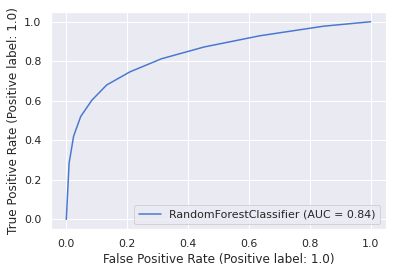

In [79]:
plot_roc_curve(model, X_valid, y_valid)
plt.show()

Looking at the scores in the original SUSY article, we see that our super simple model does not perform too badly - with an AUC of around 0.84 it falls short of the benchmark models by around 3-5% with the "complete" features. In the coming lessons we will explore techniques to improve upon this!

<div style="text-align: center">
<img src='images/susy_benchmark.png'>
   <p style="text-align: center;"> <b>Figure reference:</b> https://www.nature.com/articles/ncomms5308 </p>
</div>